# **Notebook: Clasificación del clima en Bilbao con Gradient Boosting**

En este cuaderno:
1. Cargamos y exploramos el dataset `all_weather_data.csv`.
2. Filtramos la información por la ciudad de *Bilbao*.
3. Analizamos los tipos de clima en la columna `Weather`.
4. Mostramos la **matriz de covarianza** de las columnas numéricas.
5. Reducimos dimensionalidad (PCA) para *visualizar* los datos en 2D o 3D (opcional).
6. Entrenamos un **Gradient Boosting** para predecir el tipo de clima.
7. Evaluamos el rendimiento del modelo.


In [12]:
# CELDA 1: Importar librerías necesarias
# Comentario: Cargamos librerías para análisis, gráficos y modelado.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para dividir datos y evaluar el rendimiento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Para preprocesamiento y modelado
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
# CELDA 2: Cargar y explorar la base de datos
# Comentario: Leemos el CSV, mostramos ejemplos y analizamos columnas.
df = pd.read_csv('all_weather_data.csv')  # Ajusta la ruta si fuera necesario

# Observamos las primeras filas
display(df.head())

# Mostramos información general
df.info()

# Chequeamos valores únicos en la columna Weather para ver si hay más tipos
tipos_clima = df['Weather'].unique()
print("Tipos de clima en la columna 'Weather':")
print(tipos_clima)

# Descripción estadística rápida
display(df.describe(include='all'))

,Timestamp,Temperature (ºC),Wind Speed (m/s),Wind Direction (degrees),Pressure (hPa),Humidity (%),Weather,City
0,2023-07-12 15:00:00,28.78,5.66,120,1014,70,Clouds,Barcelona
1,2023-07-12 16:00:00,28.31,5.14,140,1014,72,Clouds,Barcelona
2,2023-07-12 17:00:00,27.81,3.60,120,1014,73,Clear,Barcelona
3,2023-07-12 18:00:00,27.27,3.09,130,1013,76,Clear,Barcelona
4,2023-07-12 19:00:00,26.99,2.57,130,1014,77,Clear,Barcelona


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78624 entries, 0 to 78623
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Timestamp                 78624 non-null  object 
 1   Temperature (ºC)          78624 non-null  float64
 2   Wind Speed (m/s)          78624 non-null  float64
 3   Wind Direction (degrees)  78624 non-null  int64  
 4   Pressure (hPa)            78624 non-null  int64  
 5   Humidity (%)              78624 non-null  int64  
 6   Weather                   78624 non-null  object 
 7   City                      78624 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 4.8+ MB
Tipos de clima en la columna 'Weather':
['Clouds' 'Clear' 'Thunderstorm' 'Rain' 'Drizzle' 'Mist' 'Fog' 'Snow'
 'Smoke' 'Haze']


,Timestamp,Temperature (ºC),Wind Speed (m/s),Wind Direction (degrees),Pressure (hPa),Humidity (%),Weather,City
count,78624,78624.000000,78624.000000,78624.000000,78624.000000,78624.000000,78624,78624
unique,8736,NaN,NaN,NaN,NaN,NaN,10,9
top,2023-07-12 15:00:00,NaN,NaN,NaN,NaN,NaN,Clear,Barcelona
freq,9,NaN,NaN,NaN,NaN,NaN,40224,8736
mean,NaN,18.233937,3.677747,189.093292,1016.021418,63.702508,NaN,NaN
std,NaN,7.683856,2.474032,108.461413,7.189041,19.057579,NaN,NaN
min,NaN,-3.950000,0.000000,0.000000,946.000000,8.000000,NaN,NaN
25%,NaN,12.640000,2.060000,90.000000,1013.000000,50.000000,NaN,NaN
50%,NaN,18.190000,3.090000,220.000000,1016.000000,67.000000,NaN,NaN
75%,NaN,23.742500,4.920000,290.000000,1020.000000,79.000000,NaN,NaN


### Filtro: sólo Bilbao
En caso de que existan muchas ciudades, quedémonos con *Bilbao* para el análisis local.


In [14]:
# CELDA 3: Filtrar solo filas de Bilbao
# Comentario: Asumimos que la columna se llama 'City'.
df_bilbao = df[df['City'] == 'Bilbao'].copy()
print(f"Filas totales para Bilbao: {len(df_bilbao)}")
display(df_bilbao.head())

# Si 'df_bilbao' quedara vacío, revisa que la columna City contenga efectivamente 'Bilbao'.

Filas totales para Bilbao: 8736


,Timestamp,Temperature (ºC),Wind Speed (m/s),Wind Direction (degrees),Pressure (hPa),Humidity (%),Weather,City
8736,2023-07-12 15:00:00,26.00,5.14,340,1019,59,Clouds,Bilbao
8737,2023-07-12 16:00:00,24.61,4.12,350,1020,63,Rain,Bilbao
8738,2023-07-12 17:00:00,22.94,2.57,320,1020,70,Rain,Bilbao
8739,2023-07-12 18:00:00,21.64,2.57,340,1020,75,Rain,Bilbao
8740,2023-07-12 19:00:00,21.39,1.03,0,1020,76,Clouds,Bilbao


## Preparar datos para la clasificación
Nuestro objetivo es predecir la columna **`Weather`**. Como es una **variable categórica con múltiples clases** (Clouds, Rain, Clear, etc.), usaremos un **Label Encoder** para transformarla en valores numéricos.

In [23]:
# CELDA 5: Preparar X e y
# Comentario: 'Weather' será nuestro target, pero lo convertiremos en 2 clases: 'Good Weather' y 'Bad Weather'.

df_bilbao_clean = df_bilbao_numeric.copy()
# Copiamos las columnas numéricas en df_bilbao_clean (por si quieres usarlo luego).

# Definimos qué categorías consideramos como 'Good Weather'
# Ejemplo: 'Clear' y 'Clouds' = Good Weather
#          Resto de estados climáticos = Bad Weather
def categorize_weather(clima):
    if clima in ['Clear', 'Clouds']:
        return 'Good Weather'
    else:
        return 'Bad Weather'

# Creamos una nueva columna binaria con Good/Bad Weather
df_bilbao['Weather_Binary'] = df_bilbao['Weather'].apply(categorize_weather)

# Ahora aplicamos Label Encoding, de modo que 'Good Weather' = 0 (por ejemplo), 'Bad Weather' = 1
le = LabelEncoder()
df_bilbao['Weather_Enc'] = le.fit_transform(df_bilbao['Weather_Binary'])

# Definimos las características numéricas (X) -> usa df_bilbao_numeric
X = df_bilbao_numeric.values  # shape: (n_muestras, n_features)

# El vector objetivo (y) son las 2 clases (Good/Bad) codificadas a 0/1
y = df_bilbao['Weather_Enc'].values

print("Dimensión de X:", X.shape)
print("Dimensión de y:", y.shape)
print("Clases finales:", le.classes_)


Dimensión de X: (8736, 6)
Dimensión de y: (8736,)
Clases finales: ['Bad Weather' 'Good Weather']


## Matriz de covarianza
Analizamos únicamente las columnas numéricas para calcular su **covarianza**.

Matriz de Correlación (Bilbao) con Weather Enc:


,Temperature (ºC),Wind Speed (m/s),Wind Direction (degrees),Pressure (hPa),Humidity (%),Weather_Enc
Temperature (ºC),1.000000,-0.007860,0.106394,-0.328155,-0.514278,0.097815
Wind Speed (m/s),-0.007860,1.000000,0.493181,-0.167498,-0.151751,-0.093169
Wind Direction (degrees),0.106394,0.493181,1.000000,-0.053373,-0.010106,-0.076734
Pressure (hPa),-0.328155,-0.167498,-0.053373,1.000000,0.136789,0.135794
Humidity (%),-0.514278,-0.151751,-0.010106,0.136789,1.000000,-0.177105
Weather_Enc,0.097815,-0.093169,-0.076734,0.135794,-0.177105,1.000000


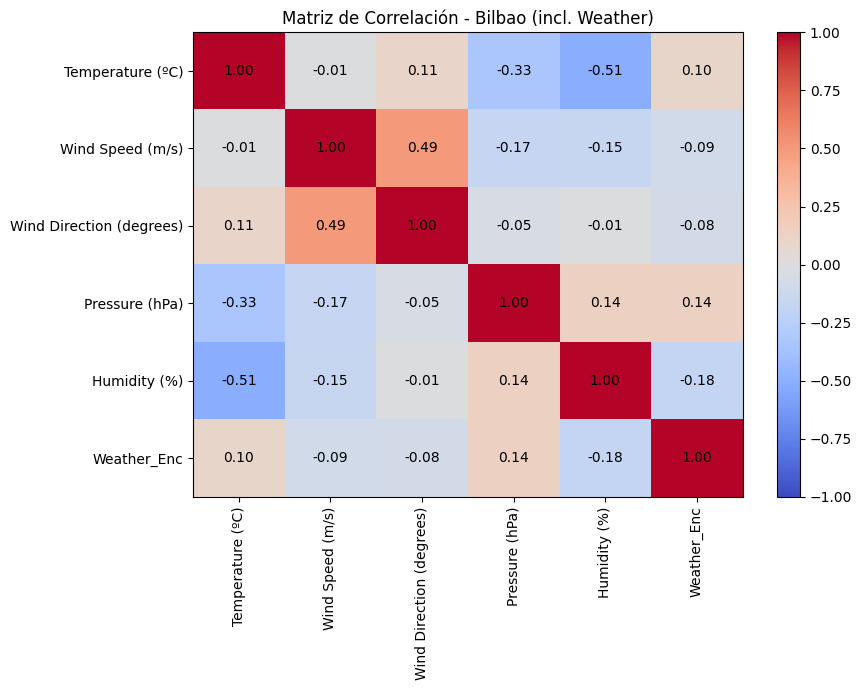

In [22]:
# CELDA 4: Matriz de correlación de columnas numéricas con valores en celdas
# Comentario: Incluimos también la variable codificada 'Weather_Enc'

# Selección de columnas numéricas
df_bilbao_numeric = df_bilbao[[
    'Temperature (ºC)', 
    'Wind Speed (m/s)', 
    'Wind Direction (degrees)', 
    'Pressure (hPa)', 
    'Humidity (%)'
]].copy()

# Añadir columna binaria del clima
df_bilbao_numeric['Weather_Enc'] = df_bilbao['Weather_Enc']

# Calcular la matriz de correlación
corr_matrix = df_bilbao_numeric.corr()
print("Matriz de Correlación (Bilbao) con Weather Enc:")
display(corr_matrix)

# Visualización con valores numéricos en las celdas
plt.figure(figsize=(9, 7))
im = plt.imshow(corr_matrix, interpolation='nearest', aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlación - Bilbao (incl. Weather)")
plt.colorbar(im)

# Etiquetas de los ejes
labels = corr_matrix.columns
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)

# Añadir los valores en las celdas
for i in range(len(labels)):
    for j in range(len(labels)):
        value = corr_matrix.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


## Representación en Función de las 3 Variables más Representativas
Aquí hacemos PCA a 2D (o 3D) para ver si hay alguna separación clara entre los distintos tipos de clima.

In [32]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Verificamos forma y columnas
print("Tamaño de df_bilbao:", df_bilbao.shape)
print("Columnas:", df_bilbao.columns)

# Mostramos ejemplos
display(df_bilbao.head())

# Columnas clave
features_3d = ['Temperature (ºC)', 'Pressure (hPa)', 'Humidity (%)']

# Eliminamos filas con NaNs en esas columnas y en Weather_Enc
df_bilbao_check = df_bilbao.dropna(subset=features_3d + ['Weather_Enc']).copy()

# Revisa tipo y valores de 'Weather_Enc'
print("\nValores únicos en 'Weather_Enc' antes de conversión:", df_bilbao_check['Weather_Enc'].unique())
print("Tipo de datos de 'Weather_Enc':", df_bilbao_check['Weather_Enc'].dtype)

# Convertimos a int
df_bilbao_check['Weather_Enc'] = df_bilbao_check['Weather_Enc'].astype(int)

# Map a Good y Bad
df_bilbao_check['Weather_str'] = df_bilbao_check['Weather_Enc'].map({0: 'Good', 1: 'Bad'})

print("Conteo de 'Weather_str':\n", df_bilbao_check['Weather_str'].value_counts())

# Estandarizar variables
scaler = StandardScaler()
X_3d_scaled = scaler.fit_transform(df_bilbao_check[features_3d])

# Creamos DataFrame escalado
df_plot_3d = pd.DataFrame(X_3d_scaled, columns=features_3d)

# Adjuntamos la columna con Good/Bad
df_plot_3d['Weather_str'] = df_bilbao_check['Weather_str'].values

# Graficamos con Plotly
fig = px.scatter_3d(
    df_plot_3d,
    x='Temperature (ºC)',
    y='Pressure (hPa)',
    z='Humidity (%)',
    color='Weather_str',      # 'Good' o 'Bad'
    symbol='Weather_str',     # un símbolo distinto por clase
    title="Distribución 3D del Clima (Bilbao)"
)

# Ejes
fig.update_layout(scene=dict(
    xaxis_title='Temperatura (ºC)',
    yaxis_title='Presión (hPa)',
    zaxis_title='Humedad (%)'
))

# Ajustar tamaño de puntos
fig.update_traces(marker=dict(size=4))

# Mostrar en el navegador (útil en VSCode)
fig.show(renderer="browser")


Tamaño de df_bilbao: (8736, 10)
Columnas: Index(['Timestamp', 'Temperature (ºC)', 'Wind Speed (m/s)',
       'Wind Direction (degrees)', 'Pressure (hPa)', 'Humidity (%)', 'Weather',
       'City', 'Weather_Binary', 'Weather_Enc'],
      dtype='object')


,Timestamp,Temperature (ºC),Wind Speed (m/s),Wind Direction (degrees),Pressure (hPa),Humidity (%),Weather,City,Weather_Binary,Weather_Enc
8736,2023-07-12 15:00:00,26.00,5.14,340,1019,59,Clouds,Bilbao,Good Weather,1
8737,2023-07-12 16:00:00,24.61,4.12,350,1020,63,Rain,Bilbao,Bad Weather,0
8738,2023-07-12 17:00:00,22.94,2.57,320,1020,70,Rain,Bilbao,Bad Weather,0
8739,2023-07-12 18:00:00,21.64,2.57,340,1020,75,Rain,Bilbao,Bad Weather,0
8740,2023-07-12 19:00:00,21.39,1.03,0,1020,76,Clouds,Bilbao,Good Weather,1



Valores únicos en 'Weather_Enc' antes de conversión: [1 0]
Tipo de datos de 'Weather_Enc': int32
Conteo de 'Weather_str':
 Weather_str
Bad     7973
Good     763
Name: count, dtype: int64


## Entrenar Gradient Boosting (multi-class)
Probaremos distintas configuraciones (n_estimators, por ejemplo) y veremos cómo varían las métricas.

In [ ]:
##############################################################################
# Entrenar GBM con 3 variables y representar en 3D las predicciones
##############################################################################

import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Seleccionar nuestras tres columnas y la clase (Weather_Enc).
#    Suponemos que en df_bilbao ya existen:
#      - 'Temperature (ºC)', 'Pressure (hPa)', 'Humidity (%)'
#      - 'Weather_Enc' (0=Good, 1=Bad)
features_3d = ['Temperature (ºC)', 'Pressure (hPa)', 'Humidity (%)']

df_bilbao_3cols = df_bilbao.dropna(subset=features_3d + ['Weather_Enc']).copy()

# 2) Escalar las tres columnas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_bilbao_3cols[features_3d])
y = df_bilbao_3cols['Weather_Enc'].astype(int).values  # Aseguramos tipo int

# 3) Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 4) Entrenar Gradient Boosting con distintas cantidades de n_estimators
n_estimators_list = [10, 50, 100, 1000]
for n_est in n_estimators_list:
    gb_model = GradientBoostingClassifier(
        n_estimators=n_est,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    
    # Métricas en el set de test
    y_pred_test = gb_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_test)
    print(f"GBM con n_estimators={n_est}: Accuracy en test = {acc:.3f}")
    
    # 5) Predicción para TODOS los registros (X_scaled) para graficarlos en 3D
    y_pred_all = gb_model.predict(X_scaled)
    
    # Pasamos a DataFrame con las tres variables escaladas
    df_plot_3d = pd.DataFrame(X_scaled, columns=features_3d)
    
    # Convertimos la predicción (0/1) a strings 'Good'/'Bad'
    df_plot_3d['Predicted'] = y_pred_all
    df_plot_3d['Predicted_str'] = df_plot_3d['Predicted'].map({0: 'Good', 1: 'Bad'})
    
    # 6) Gráfico 3D: cada punto se colorea según su clase predicha
    fig = px.scatter_3d(
        df_plot_3d,
        x='Temperature (ºC)',
        y='Pressure (hPa)',
        z='Humidity (%)',
        color='Predicted_str',
        symbol='Predicted_str',
        title=f"GBM (n_estimators={n_est}) - Predicciones 3D"
    )
    fig.update_layout(scene=dict(
        xaxis_title='Temperatura (ºC)',
        yaxis_title='Presión (hPa)',
        zaxis_title='Humedad (%)'
    ))
    fig.update_traces(marker=dict(size=4))
    
    # Mostramos la figura (en VSCode, se sugiere renderer='browser')
    fig.show(renderer="browser")

# 7) Entrenamos un modelo final con n_estimators=100 (por ejemplo) y mostramos reporte
print("\n--- Modelo final con 100 estimadores ---")
final_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
final_model.fit(X_train, y_train)

y_pred_final = final_model.predict(X_test)
acc_final = accuracy_score(y_test, y_pred_final)
print(f"Accuracy final: {acc_final:.3f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_final, target_names=['Good', 'Bad']))

cm = confusion_matrix(y_test, y_pred_final)
print("Matriz de confusión:")
print(cm)


GBM con n_estimators=10: Accuracy en test = 0.907
GBM con n_estimators=50: Accuracy en test = 0.910
GBM con n_estimators=100: Accuracy en test = 0.910
GBM con n_estimators=1000: Accuracy en test = 0.902

--- Modelo final con 100 estimadores ---
Accuracy final: 0.910

Reporte de clasificación:
              precision    recall  f1-score   support

        Good       0.60      0.07      0.13       162
         Bad       0.91      0.99      0.95      1586

    accuracy                           0.91      1748
   macro avg       0.76      0.53      0.54      1748
weighted avg       0.88      0.91      0.88      1748

Matriz de confusión:
[[  12  150]
 [   8 1578]]


## Entrenar eXtreme Gradient Boosting (multi-class)
Probaremos distintas configuraciones (n_estimators, por ejemplo) y veremos cómo varían las métricas.

In [37]:
##############################################################################
# Uso de XGBoost para predecir (Good vs Bad Weather) con 3 variables
##############################################################################
# !pip install xgboost  # Descomenta si no lo tienes instalado

import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import xgboost as xgb  # Importamos la librería XGBoost

# 1) Seleccionar nuestras tres columnas y la clase (Weather_Enc).
features_3d = ['Temperature (ºC)', 'Pressure (hPa)', 'Humidity (%)']

# Suponiendo que df_bilbao ya existe y contiene Weather_Enc (0=Good,1=Bad)
df_bilbao_3cols = df_bilbao.dropna(subset=features_3d + ['Weather_Enc']).copy()

# 2) Escalar las tres columnas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_bilbao_3cols[features_3d])
y = df_bilbao_3cols['Weather_Enc'].astype(int).values

# 3) Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# 4) Definimos el modelo XGBoost
# Aquí usamos algunos parámetros clave
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42
)

# Entrenamos
xgb_model.fit(X_train, y_train)

# 5) Evaluación en test
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost - Accuracy en test: {acc:.3f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Good','Bad']))

# 6) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

# 7) Visualización 3D de predicciones
# Predicción de TODO X_scaled para graficar
y_pred_all = xgb_model.predict(X_scaled)

df_plot_3d = pd.DataFrame(X_scaled, columns=features_3d)
df_plot_3d['Predicted'] = y_pred_all
df_plot_3d['Predicted_str'] = df_plot_3d['Predicted'].map({0: 'Good', 1: 'Bad'})

fig = px.scatter_3d(
    df_plot_3d,
    x='Temperature (ºC)',
    y='Pressure (hPa)',
    z='Humidity (%)',
    color='Predicted_str',
    symbol='Predicted_str',
    title="XGBoost - Predicción de clima (Bilbao)"
)
fig.update_layout(scene=dict(
    xaxis_title='Temperatura (ºC)',
    yaxis_title='Presión (hPa)',
    zaxis_title='Humedad (%)'
))
fig.update_traces(marker=dict(size=4))
fig.show(renderer="browser")


XGBoost - Accuracy en test: 0.909

Reporte de clasificación:
              precision    recall  f1-score   support

        Good       0.53      0.14      0.22       162
         Bad       0.92      0.99      0.95      1586

    accuracy                           0.91      1748
   macro avg       0.73      0.56      0.59      1748
weighted avg       0.88      0.91      0.88      1748

Matriz de confusión:
[[  23  139]
 [  20 1566]]
